In [4]:
import pandas as pd
import numpy as np
import os

from xgboost import XGBRegressor
from sklearn.model_selection import  KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
# Ensure results directory exists
os.makedirs("monthly_results", exist_ok=True)

In [6]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [109]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
    'windspeed_10m',
    'windspeed_100m',
    'windgusts_10m',
    'Power_lag1', 
    'Power_lag3', 
    'Power_lag6', 
    'Power_lag12', 
    'Power_lag24',
    'Power_lag48', 
    'windspeed_10m_lag1', 
    'windspeed_10m_lag3',
    'windspeed_10m_lag6', 
    'windspeed_10m_lag12', 
    'windspeed_10m_lag24',
    'windspeed_100m_lag1', 
    'windspeed_100m_lag3', 
    'windspeed_100m_lag6',
    'windspeed_100m_lag12', 
    'windspeed_100m_lag24',
    'windgusts_10m_lag1',
    'windgusts_10m_lag3',
    'windgusts_10m_lag6',
    'windgusts_10m_lag12',
    'windgusts_10m_lag24'
]
target = 'Power'


In [110]:
# ===========================
# Lag Feature Generator
# ===========================
def generate_lag_features(df, lags_dict):
    """
    df: your full dataframe (with Timestamp as datetime column)
    lags_dict: dictionary of columns with corresponding lags
    """
    df = df.sort_values('Time').copy()  # Ensure time order
    
    for col, lags in lags_dict.items():
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    
    df = df.dropna().reset_index(drop=True)  # Drop rows with NA after shifting
    return df

In [111]:
lags_dict = {
    'Power': [1, 3, 6, 12, 24, 48],  # Power has stronger longer lags (ACF showed high persistence)
    'windspeed_10m': [1, 3, 6, 12, 24],
    'windspeed_100m': [1, 3, 6, 12, 24],
    'windgusts_10m': [1, 3, 6, 12, 24],
}

In [112]:
# Apply lag feature generation
org_train_lagged = generate_lag_features(org_train, lags_dict)
aug_train_lagged = generate_lag_features(aug_train, lags_dict)
org_test_lagged = generate_lag_features(org_test, lags_dict)

In [113]:
X_train_org = org_train_lagged[features]
y_train_org = org_train_lagged[target]

X_train_aug = aug_train_lagged[features]
y_train_aug = aug_train_lagged[target]

In [114]:
# =========================
# Define model hyperparameters
model_params = {
    'n_estimators': 200, 
    'max_depth': 6, 
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'verbosity': 0
}

In [115]:
# KFold Cross-Validation function
def kfold_cross_validate(X, y, model_params, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mae_scores, rmse_scores, r2_scores = [], [], []

    for train_index, val_index in kf.split(X):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

        model = XGBRegressor(**model_params)
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)

        mae_scores.append(mean_absolute_error(y_val_cv, y_pred_cv))
        rmse_scores.append(np.sqrt(mean_squared_error(y_val_cv, y_pred_cv)))
        r2_scores.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Cross-Validation Results (n_splits={n_splits}):")
    print(f"MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
    print(f"R2: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

In [126]:
# =========================
# KFold validation on Original data
print("Original Data Cross-Validation (XGB):")
kfold_cross_validate(X_train_org, y_train_org, model_params)

# KFold validation on Augmented data
print("\nAugmented Data Cross-Validation (XGB):")
kfold_cross_validate(X_train_aug, y_train_aug, model_params)

Original Data Cross-Validation (XGB):
Cross-Validation Results (n_splits=5):
MAE: 0.1028 ± 0.0007
RMSE: 0.1401 ± 0.0006
R2: 0.6952 ± 0.0041

Augmented Data Cross-Validation (XGB):
Cross-Validation Results (n_splits=5):
MAE: 0.1082 ± 0.0002
RMSE: 0.1473 ± 0.0004
R2: 0.6629 ± 0.0018


In [127]:
# =========================
# Final model training (train on full data after CV)
xgb_org = XGBRegressor(**model_params)
xgb_org.fit(X_train_org, y_train_org)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [128]:
xgb_aug = XGBRegressor(**model_params)
xgb_aug.fit(X_train_aug, y_train_aug)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [163]:
# Save XGB models (native method)
file_name = '../weights'
os.makedirs(file_name,exist_ok=True)
xgb_org.save_model(f"{file_name}/xgb_original_model.json")
xgb_aug.save_model(f"{file_name}/xgb_augmented_model.json")


In [129]:
# =========================
# Evaluation storage
all_results = []

# Get all unique locations
locations = org_test_lagged['Location'].unique()

for loc in locations:
    df_loc = org_test_lagged[org_test_lagged['Location'] == loc]
    
    # Iterate over months
    for month in range(1, 13):
        df_month = df_loc[df_loc['Timestamp'].dt.month == month]
        
        if df_month.empty:
            continue
        
        X_test = df_month[features]
        y_test = df_month[target]
        
        # Evaluate Original model
        y_pred_org = xgb_org.predict(X_test)
        mae_org = mean_absolute_error(y_test, y_pred_org)
        rmse_org = np.sqrt(mean_squared_error(y_test, y_pred_org))
        r2_org = r2_score(y_test, y_pred_org)

        # Evaluate Augmented model
        y_pred_aug = xgb_aug.predict(X_test)
        mae_aug = mean_absolute_error(y_test, y_pred_aug)
        rmse_aug = np.sqrt(mean_squared_error(y_test, y_pred_aug))
        r2_aug = r2_score(y_test, y_pred_aug)
        
        # Save results
        all_results.append({
            'Location': loc,
            'Month': month,
            'Model': 'Original',
            'MAE': mae_org,
            'RMSE': rmse_org,
            'R2': r2_org
        })

        all_results.append({
            'Location': loc,
            'Month': month,
            'Model': 'Augmented',
            'MAE': mae_aug,
            'RMSE': rmse_aug,
            'R2': r2_aug
        })
        
        # Save predictions for this location-month
        df_pred = df_month.copy()
        df_pred['Pred_Original_XGB'] = y_pred_org
        df_pred['Pred_Augmented_XGB'] = y_pred_aug
        
        filename = f"monthly_results/{loc}_Month_{month:02d}_xgb.csv"
        df_pred.to_csv(filename, index=False)


In [130]:

# Save full evaluation summary
results_df = pd.DataFrame(all_results)
# results_df.to_csv("monthly_results_xgb/full_evaluation_results.csv", index=False)

# print("\n✅ Monthly location-wise evaluation complete (XGB)!")

In [131]:
results_df['MAE'][results_df['Model']=='Original'].mean()


0.12056330757170491

In [132]:
results_df['MAE'][results_df['Model']=='Augmented'].mean()


0.1328732057602251

In [133]:
results_df['MAE'][results_df['Model']=='Original'].std()


0.03465940150675891

In [134]:
results_df['MAE'][results_df['Model']=='Augmented'].std()

0.03851309354028387

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

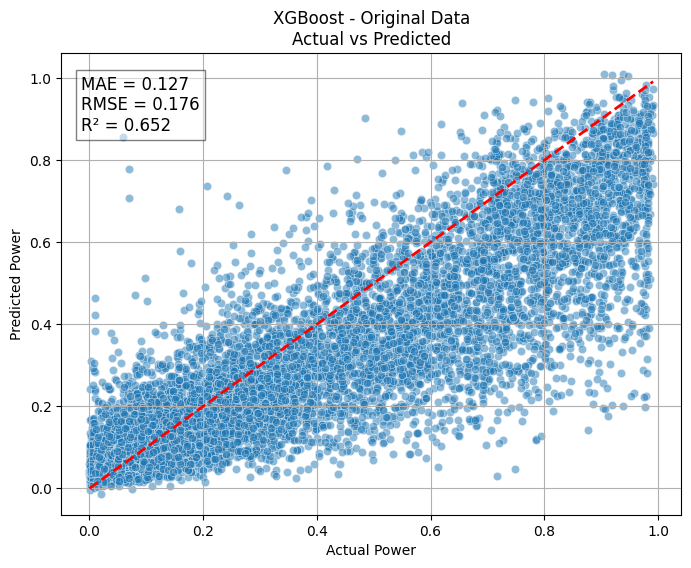

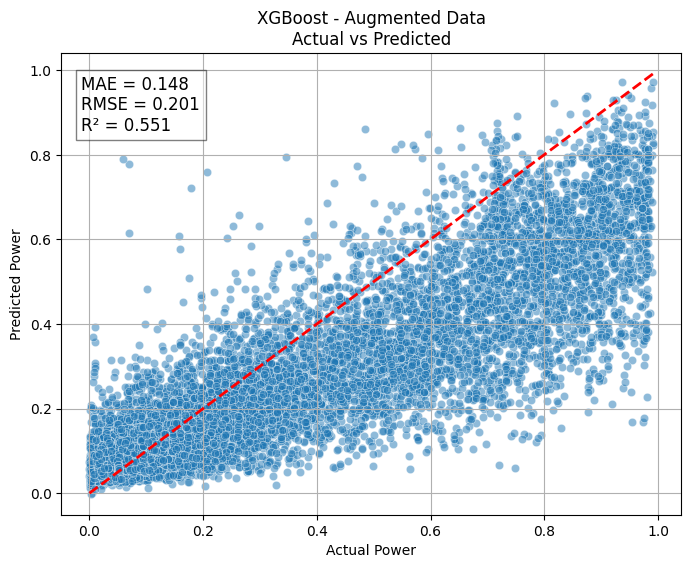

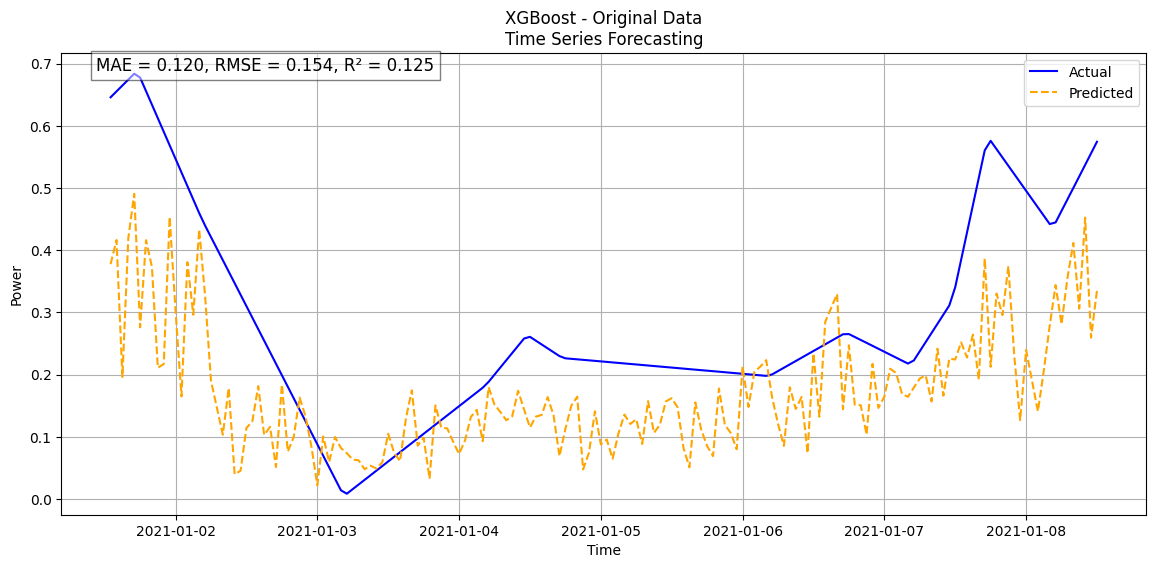

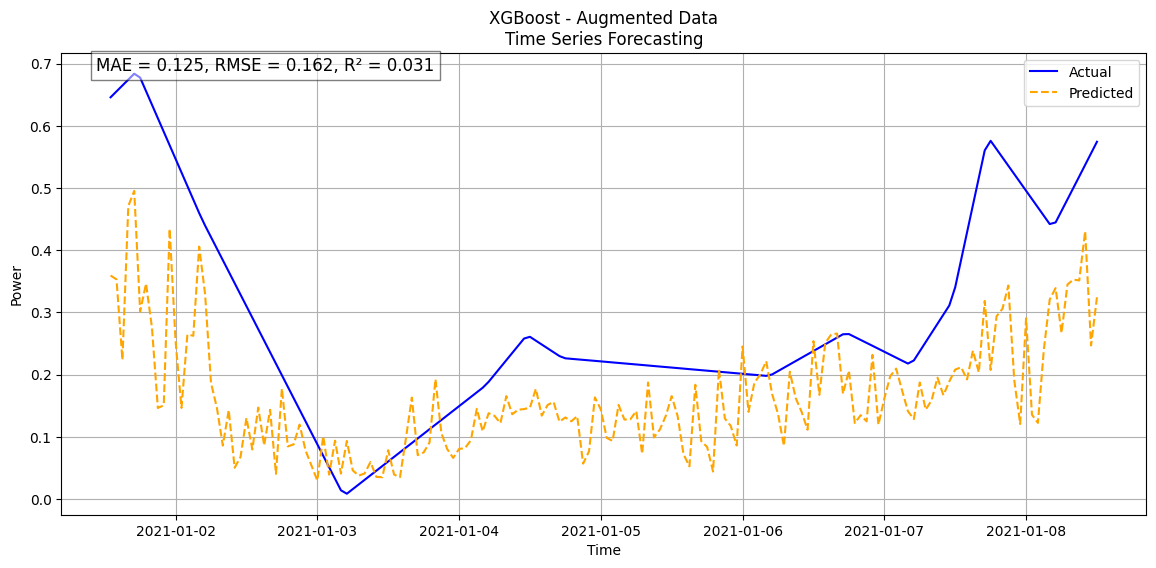

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# =========
# Functions
# =========

# Error calculation function
def calculate_errors(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Scatter Plot: Actual vs Predicted with errors
def plot_actual_vs_predicted(y_true, y_pred, model_name, dataset_name):
    mae, rmse, r2 = calculate_errors(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Power')
    plt.ylabel('Predicted Power')
    plt.title(f'{model_name} - {dataset_name}\nActual vs Predicted')
    plt.grid(True)
    
    # Error annotation
    textstr = f"MAE = {mae:.3f}\nRMSE = {rmse:.3f}\nR² = {r2:.3f}"
    plt.gcf().text(0.15, 0.75, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()

# Time Series Plot with errors
def plot_timeseries(y_true, y_pred, timestamps, model_name, dataset_name):
    mae, rmse, r2 = calculate_errors(y_true, y_pred)
    
    plt.figure(figsize=(14, 6))
    plt.plot(timestamps, y_true, label='Actual', color='blue')
    plt.plot(timestamps, y_pred, label='Predicted', color='orange', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Power')
    plt.title(f'{model_name} - {dataset_name}\nTime Series Forecasting')
    plt.legend()
    plt.grid(True)
    
    # Error annotation
    textstr = f"MAE = {mae:.3f}, RMSE = {rmse:.3f}, R² = {r2:.3f}"
    plt.gcf().text(0.15, 0.85, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()

# =========
# Apply to your full test set
# =========

# Full test data (lagged for Location1)
X_test_full = org_test_lagged[features][org_test_lagged['Location']=='Location1']
y_test_full = org_test_lagged[target][org_test_lagged['Location']=='Location1']
timestamps = org_test_lagged['Timestamp'][org_test_lagged['Location']=='Location1']

# Predict with both models
y_pred_org_xgb = xgb_org.predict(X_test_full)
y_pred_aug_xgb = xgb_aug.predict(X_test_full)

# Scatter plots
plot_actual_vs_predicted(y_test_full, y_pred_org_xgb, model_name='XGBoost', dataset_name='Original Data')
plot_actual_vs_predicted(y_test_full, y_pred_aug_xgb, model_name='XGBoost', dataset_name='Augmented Data')

# Time series plots (subset for clearer view)
subset = org_test_lagged[org_test_lagged['Location']=='Location1'].iloc[:7*4*6]
timestamps_subset = subset['Timestamp']
y_pred_org_subset = xgb_org.predict(subset[features])
y_pred_aug_subset = xgb_aug.predict(subset[features])

plot_timeseries(subset[target], y_pred_org_subset, timestamps_subset, model_name='XGBoost', dataset_name='Original Data')
plot_timeseries(subset[target], y_pred_aug_subset, timestamps_subset, model_name='XGBoost', dataset_name='Augmented Data')


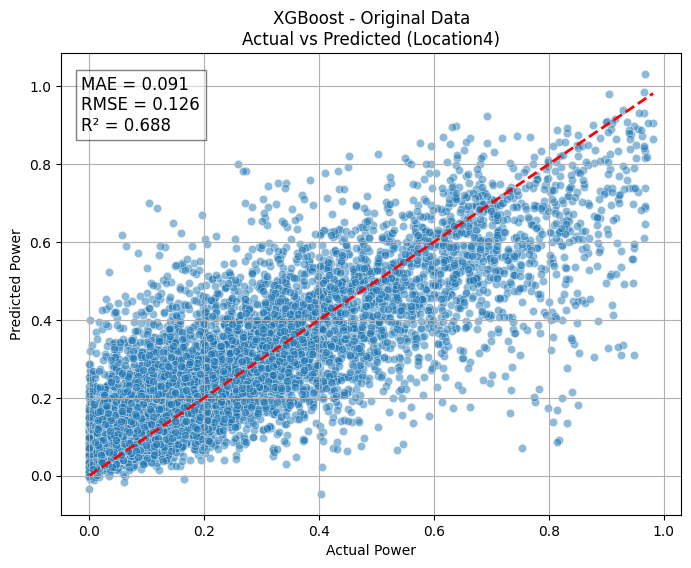

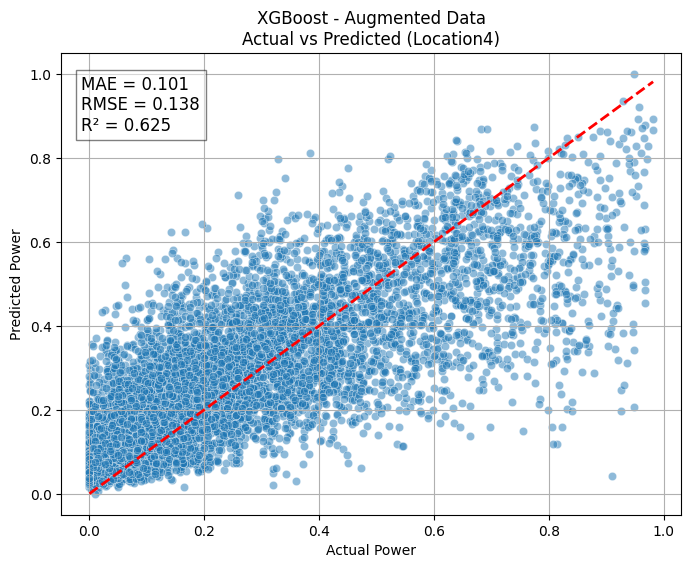

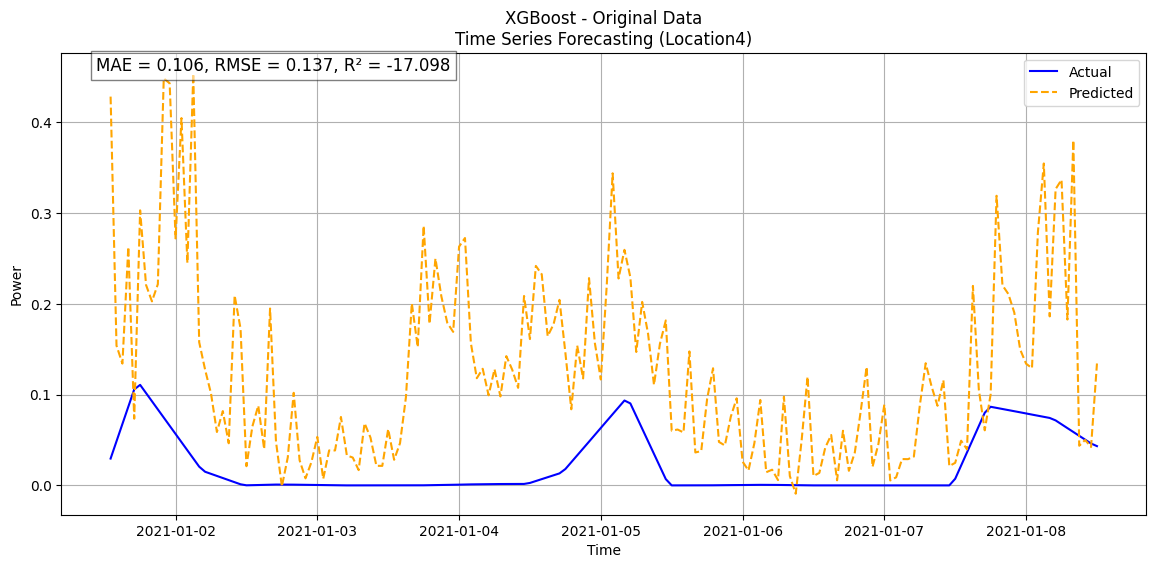

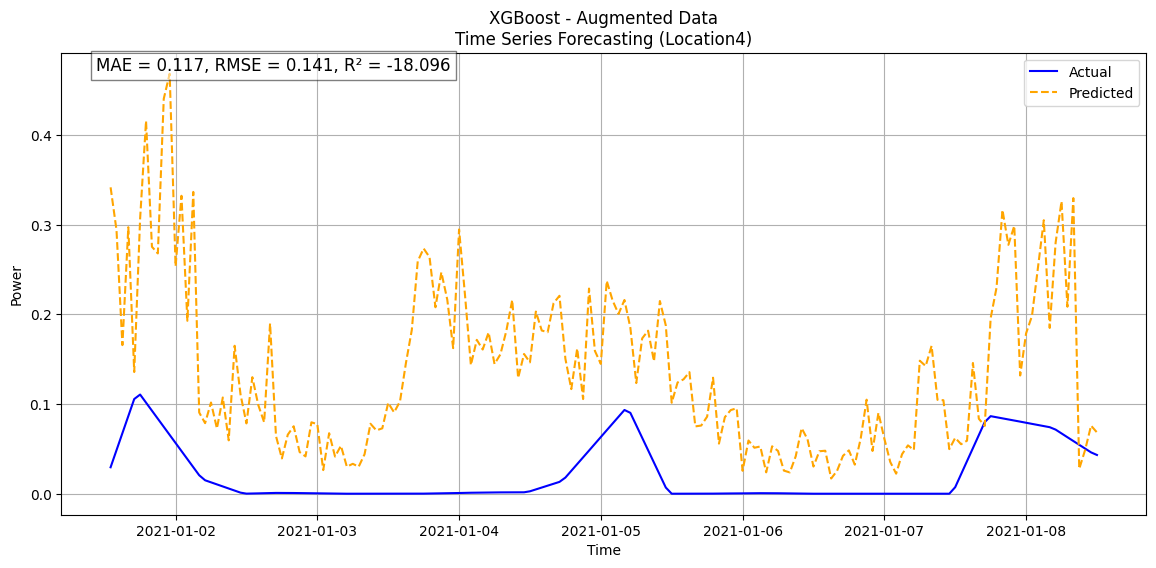

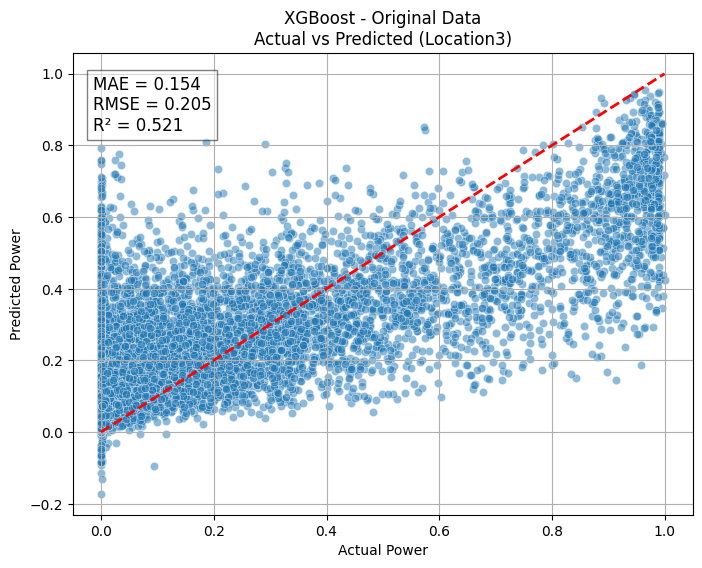

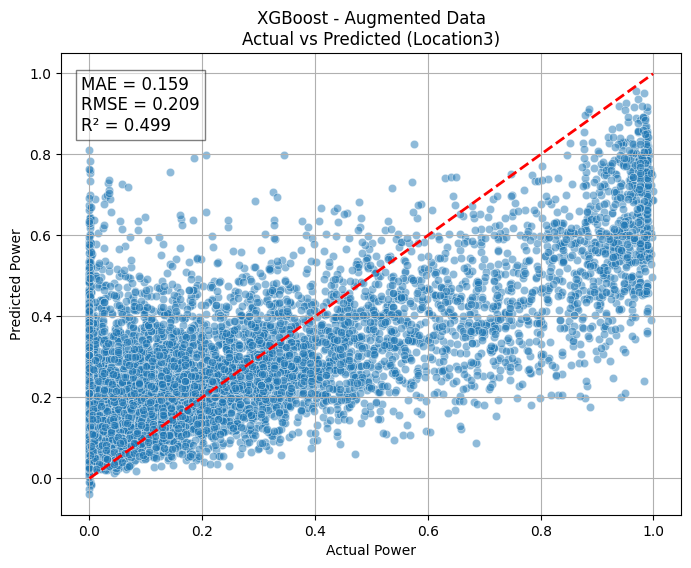

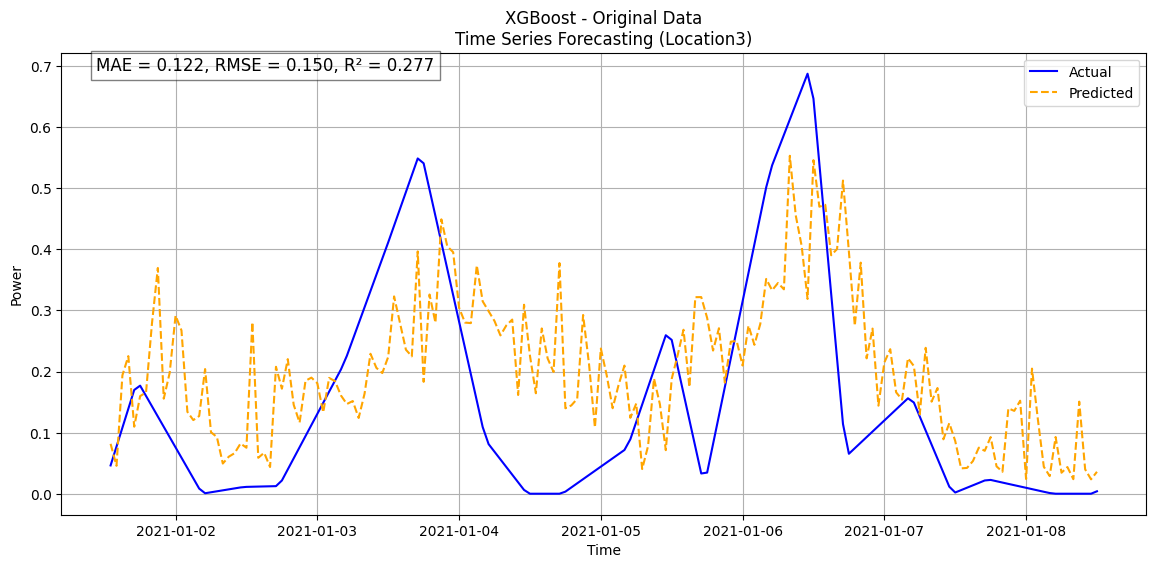

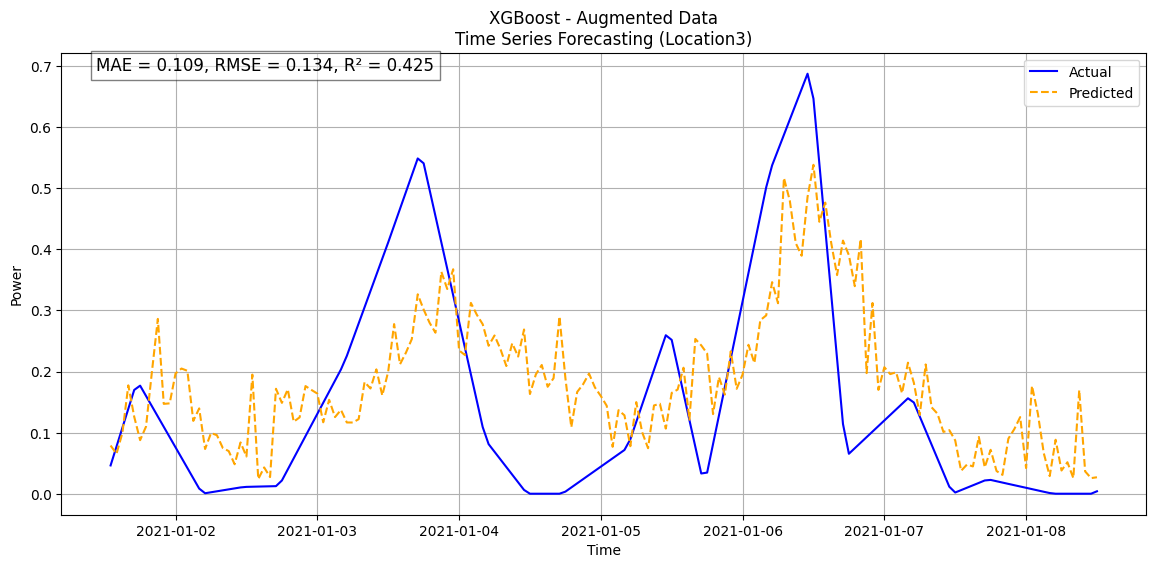

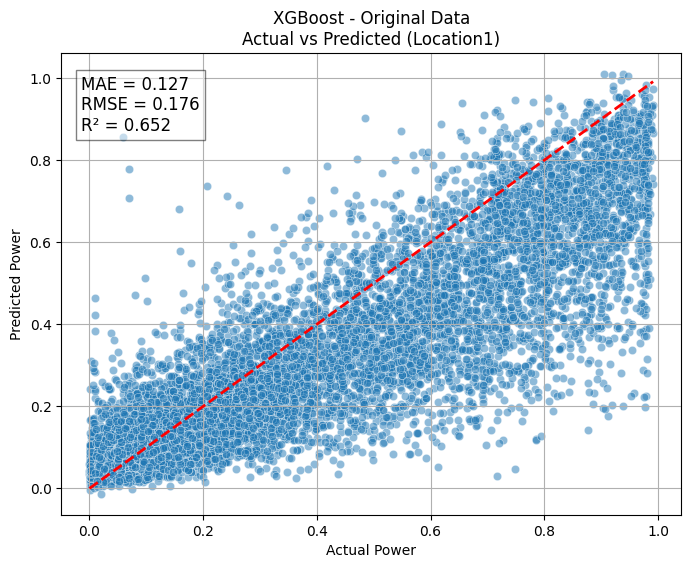

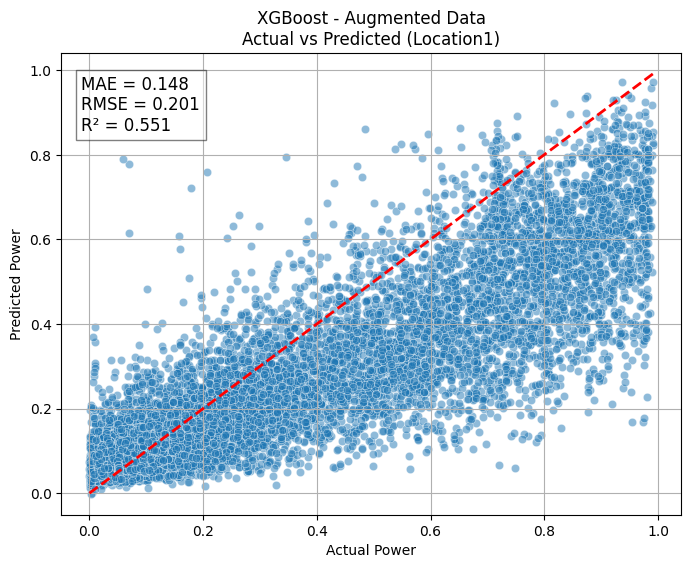

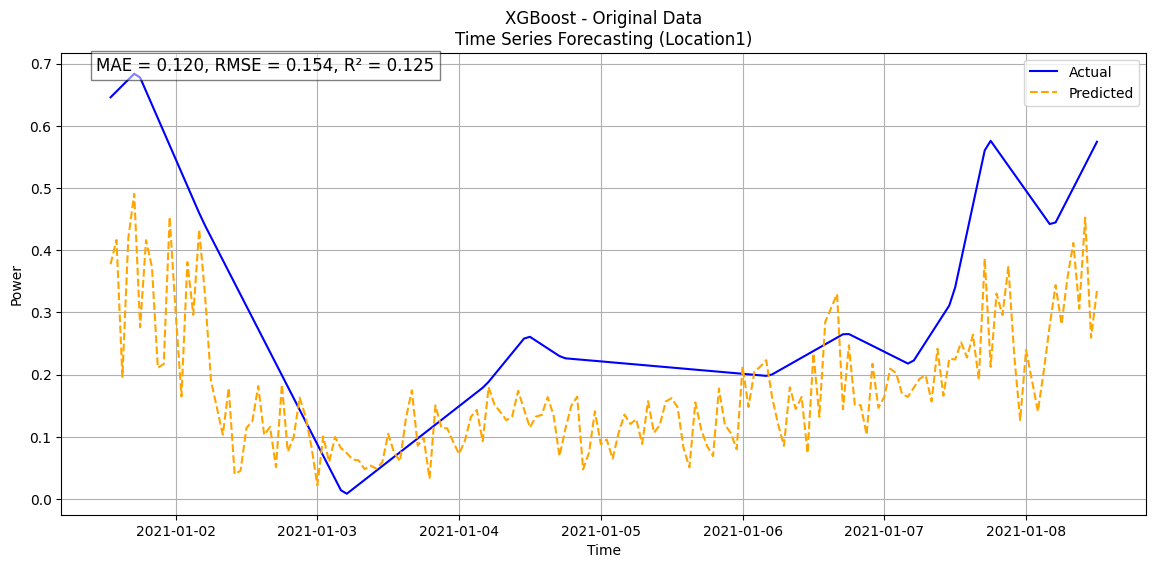

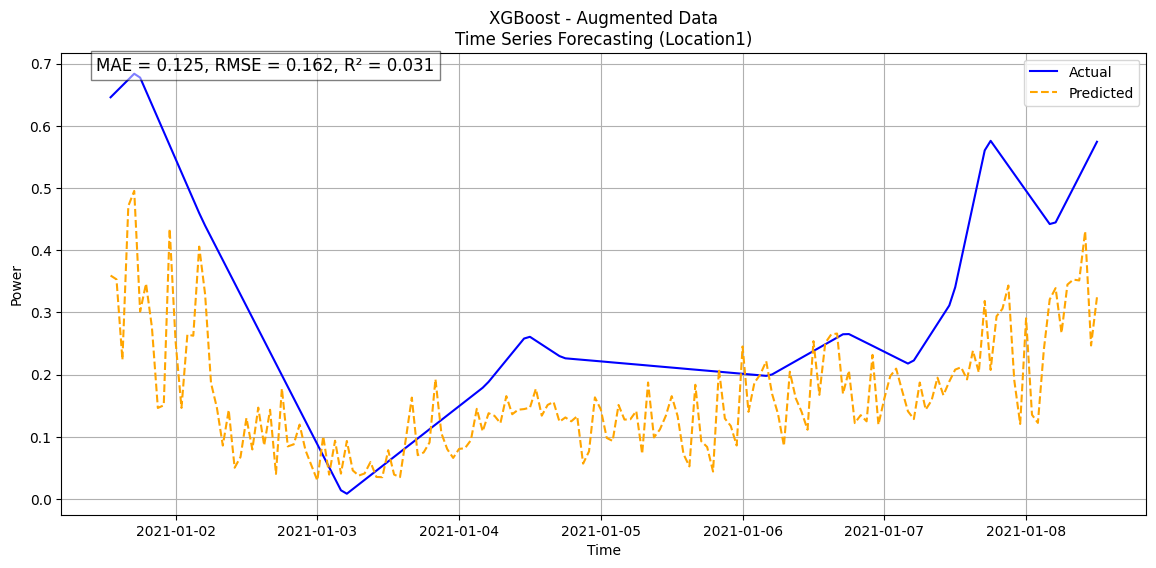

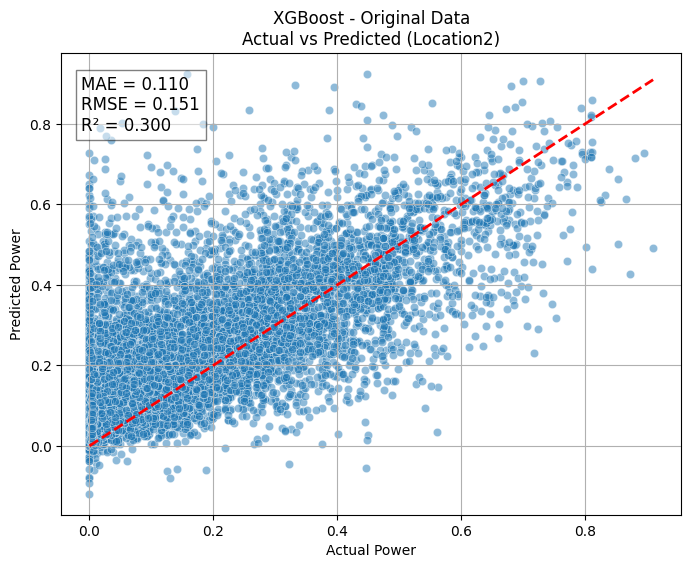

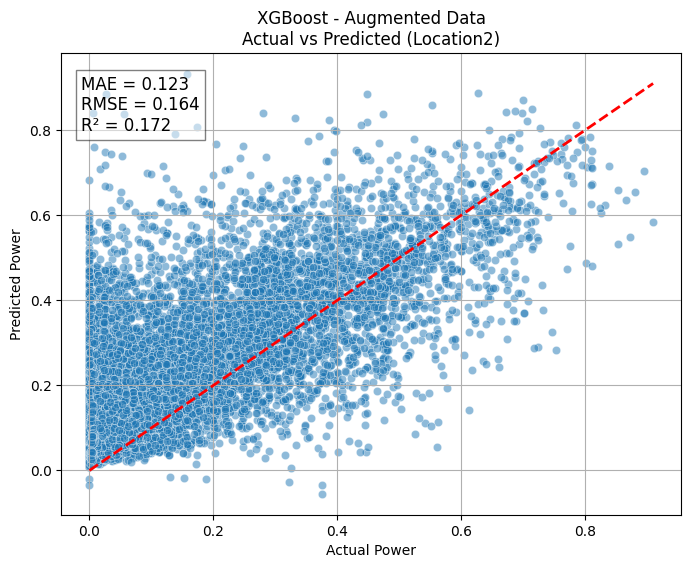

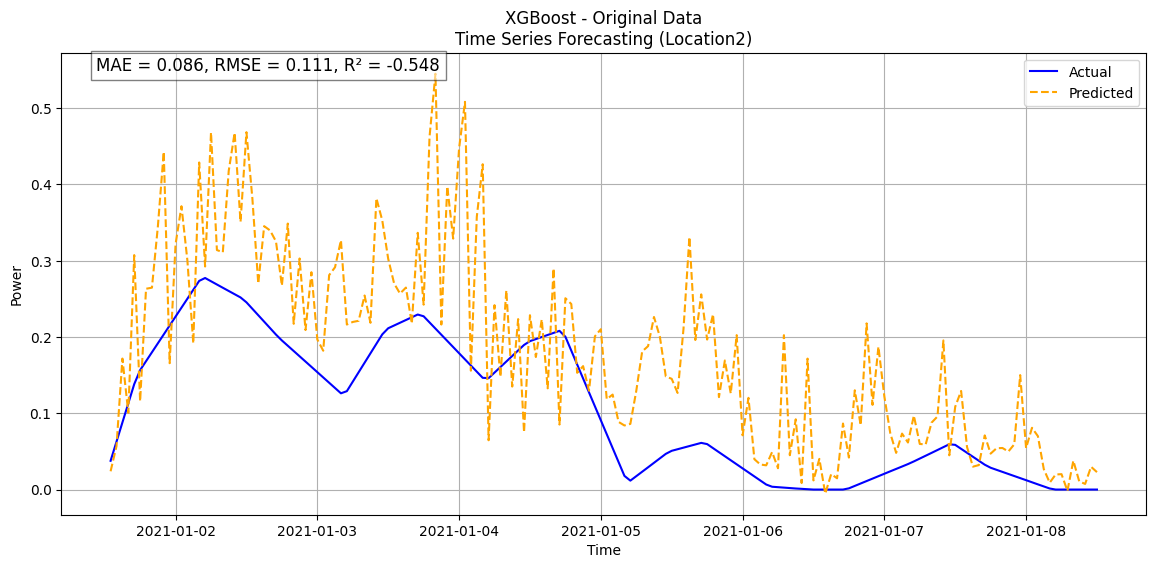

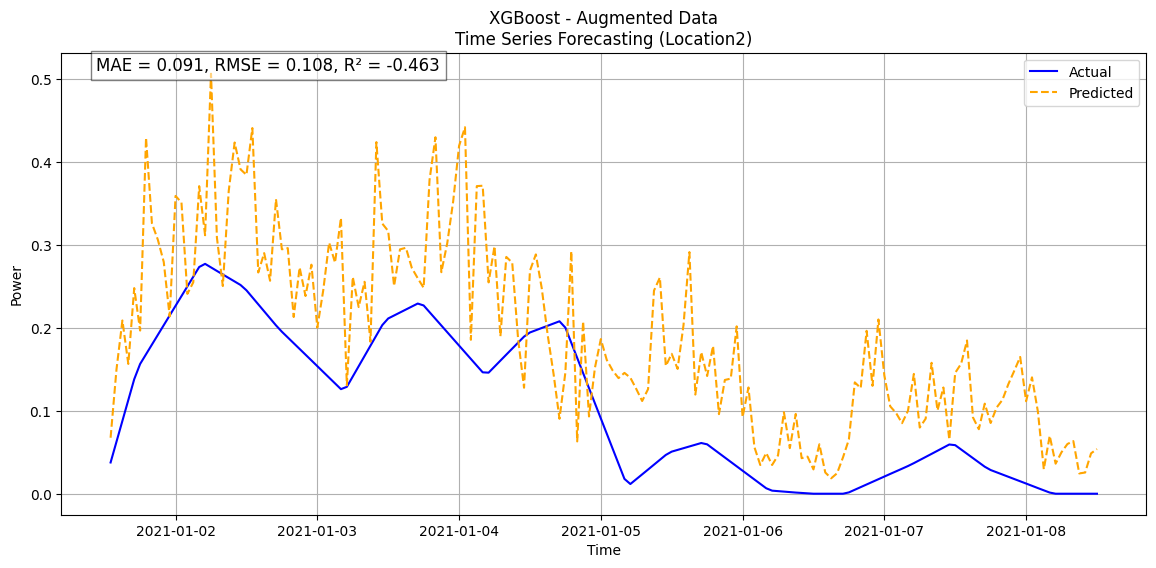

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# =========
# Functions
# =========

def calculate_errors(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def plot_actual_vs_predicted(y_true, y_pred, model_name, dataset_name, location):
    mae, rmse, r2 = calculate_errors(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Power')
    plt.ylabel('Predicted Power')
    plt.title(f'{model_name} - {dataset_name}\nActual vs Predicted ({location})')
    plt.grid(True)
    
    textstr = f"MAE = {mae:.3f}\nRMSE = {rmse:.3f}\nR² = {r2:.3f}"
    plt.gcf().text(0.15, 0.75, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

def plot_timeseries(y_true, y_pred, timestamps, model_name, dataset_name, location):
    mae, rmse, r2 = calculate_errors(y_true, y_pred)
    
    plt.figure(figsize=(14, 6))
    plt.plot(timestamps, y_true, label='Actual', color='blue')
    plt.plot(timestamps, y_pred, label='Predicted', color='orange', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Power')
    plt.title(f'{model_name} - {dataset_name}\nTime Series Forecasting ({location})')
    plt.legend()
    plt.grid(True)
    
    textstr = f"MAE = {mae:.3f}, RMSE = {rmse:.3f}, R² = {r2:.3f}"
    plt.gcf().text(0.15, 0.85, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

# =========
# Location-wise visualization
# =========

locations = org_test_lagged['Location'].unique()

for loc in locations:
    # Extract data for this location
    loc_mask = org_test_lagged['Location'] == loc
    X_test_loc = org_test_lagged[features][loc_mask]
    y_test_loc = org_test_lagged[target][loc_mask]
    timestamps_loc = org_test_lagged['Timestamp'][loc_mask]
    
    # Predictions
    y_pred_org = xgb_org.predict(X_test_loc)
    y_pred_aug = xgb_aug.predict(X_test_loc)
    
    # Scatter plots
    plot_actual_vs_predicted(y_test_loc, y_pred_org, model_name='XGBoost', dataset_name='Original Data', location=loc)
    plot_actual_vs_predicted(y_test_loc, y_pred_aug, model_name='XGBoost', dataset_name='Augmented Data', location=loc)
    
    # Time series plots (only small subset for clarity)
    subset_size = 7*4*6  # 1 week if data hourly (adjust if needed)
    subset_X = X_test_loc.iloc[:subset_size]
    subset_y = y_test_loc.iloc[:subset_size]
    subset_t = timestamps_loc.iloc[:subset_size]
    
    y_pred_org_subset = xgb_org.predict(subset_X)
    y_pred_aug_subset = xgb_aug.predict(subset_X)
    
    plot_timeseries(subset_y, y_pred_org_subset, subset_t, model_name='XGBoost', dataset_name='Original Data', location=loc)
    plot_timeseries(subset_y, y_pred_aug_subset, subset_t, model_name='XGBoost', dataset_name='Augmented Data', location=loc)


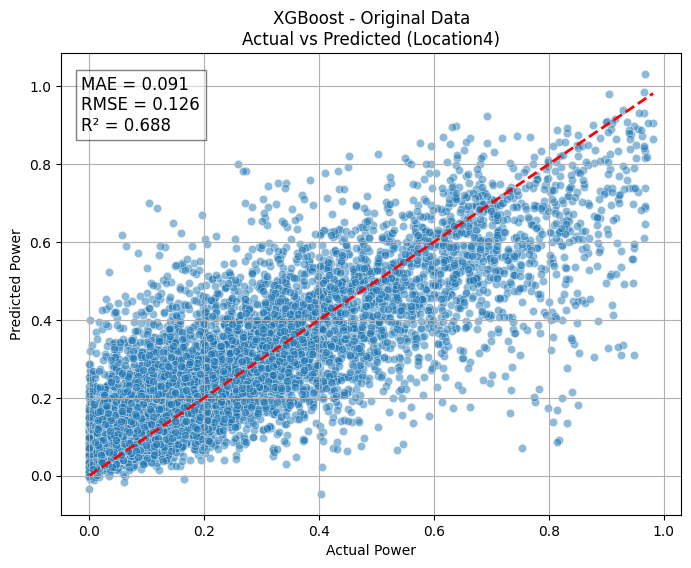

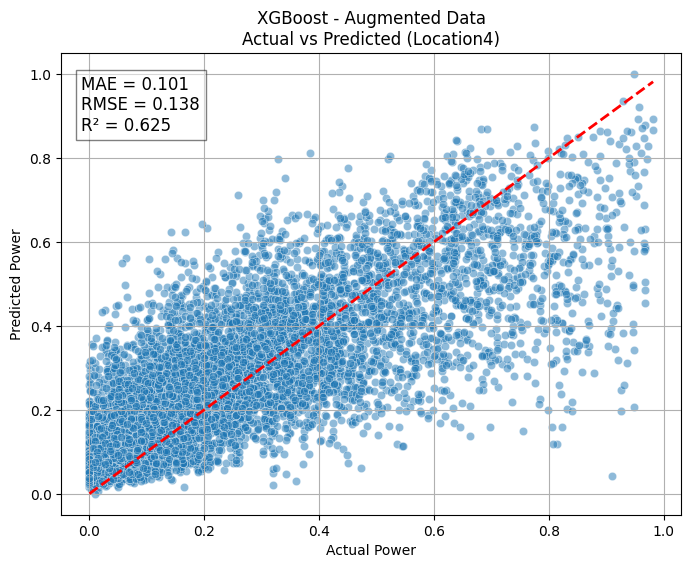

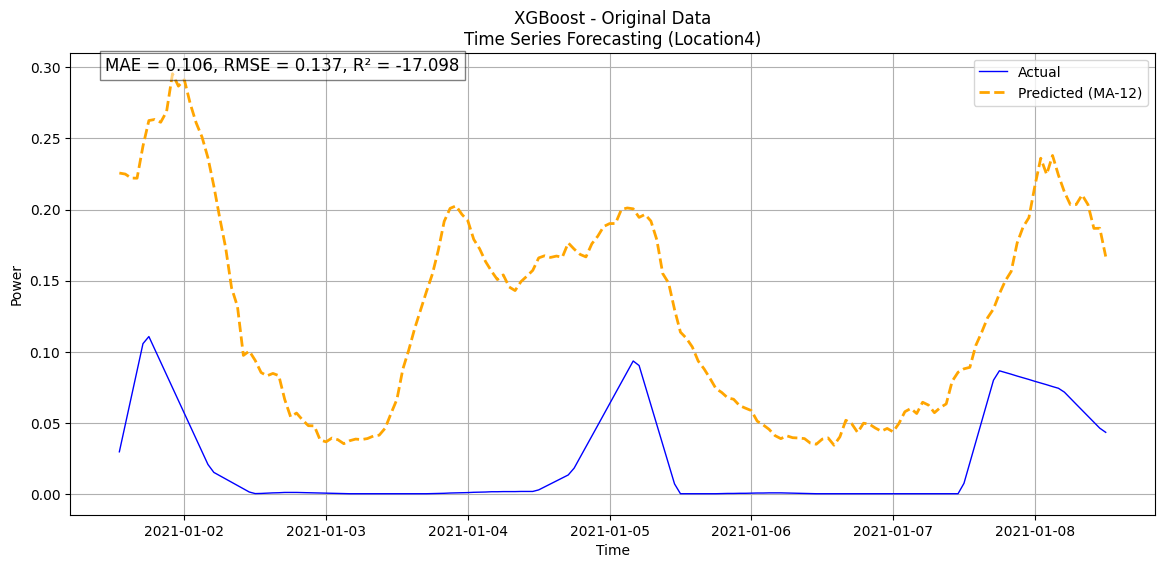

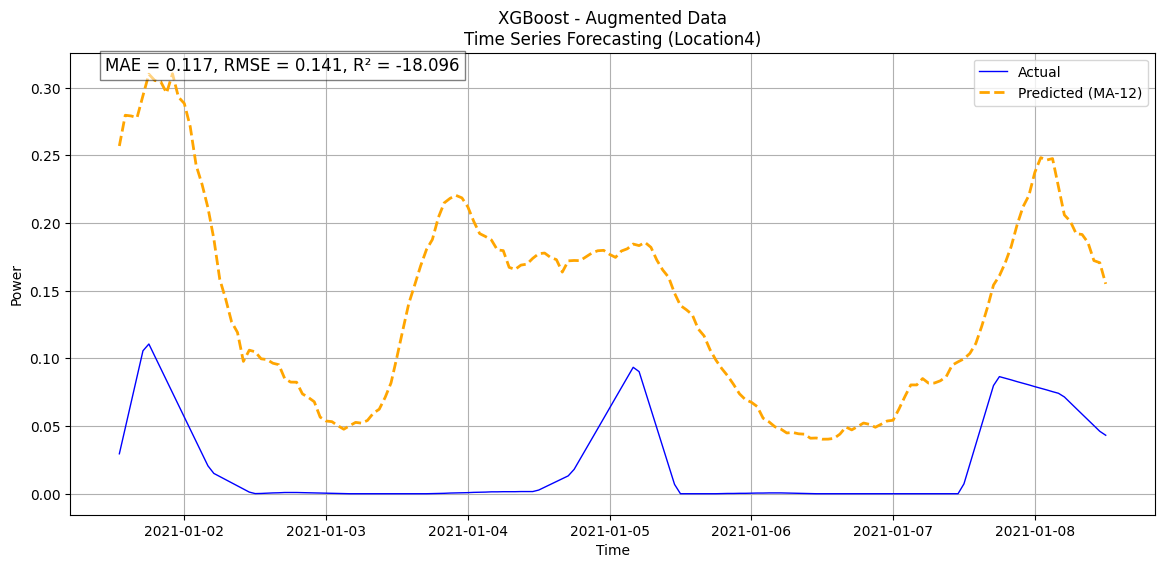

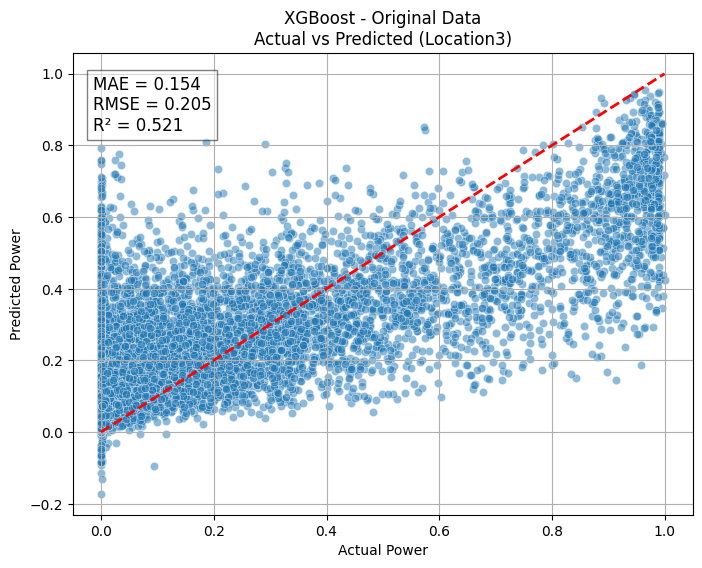

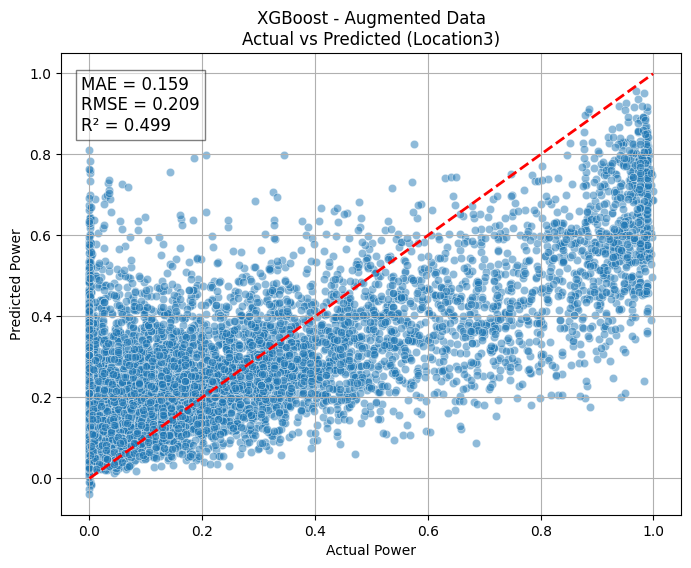

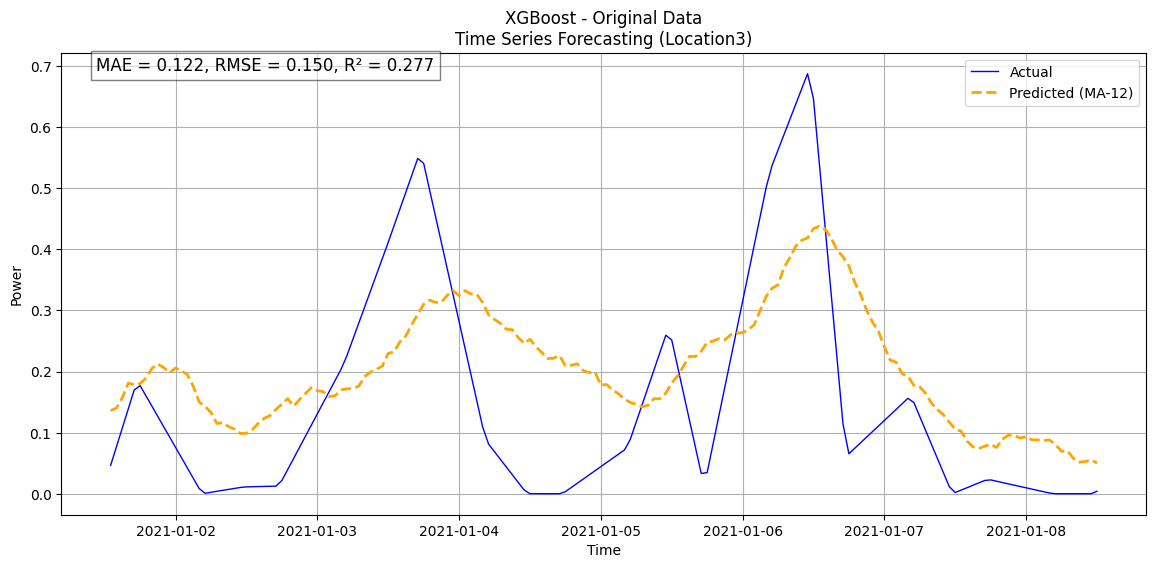

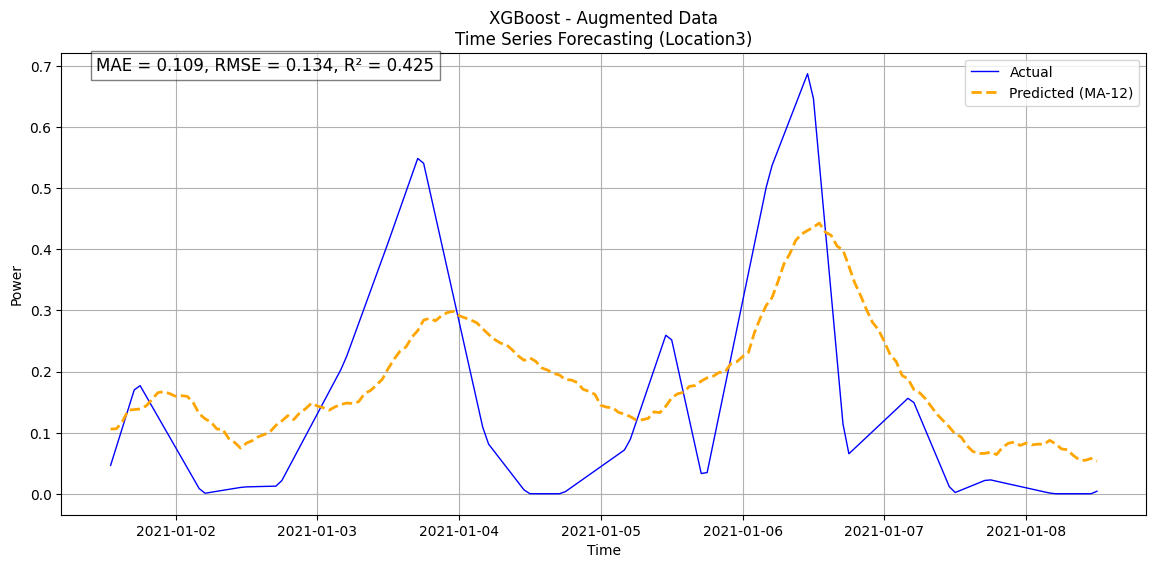

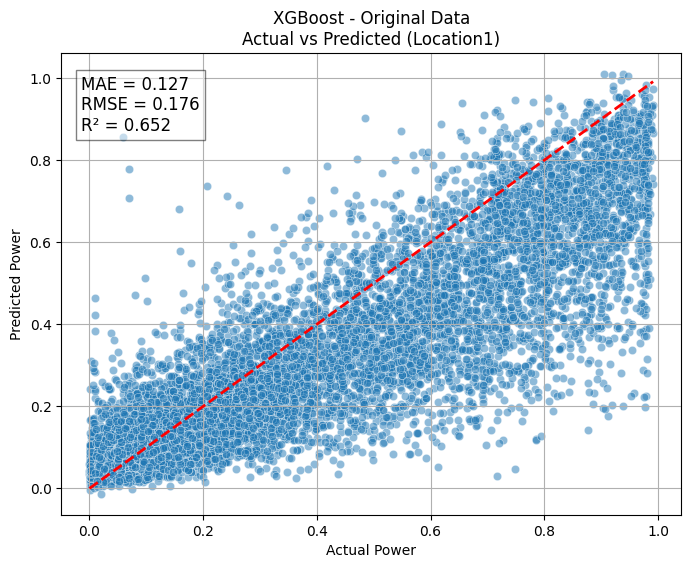

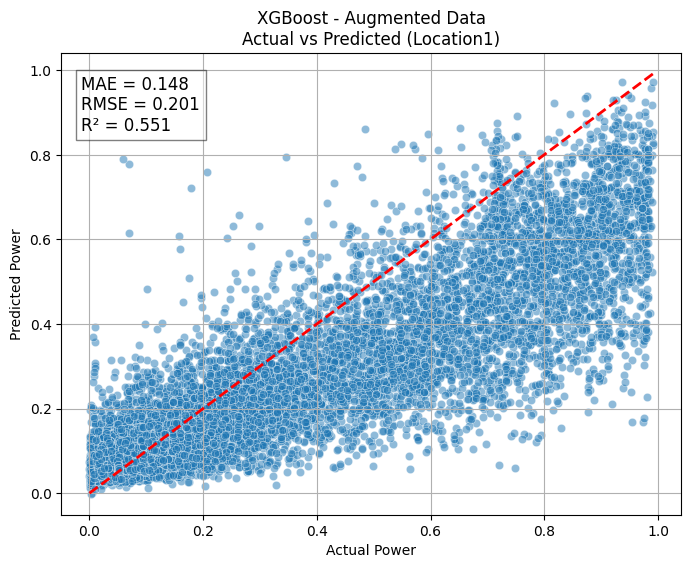

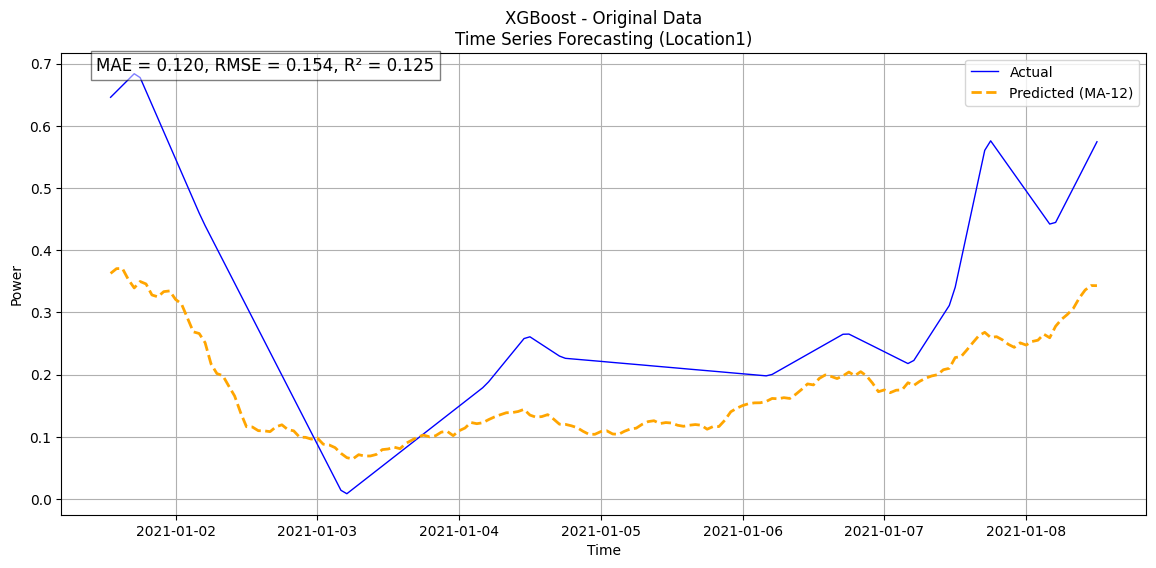

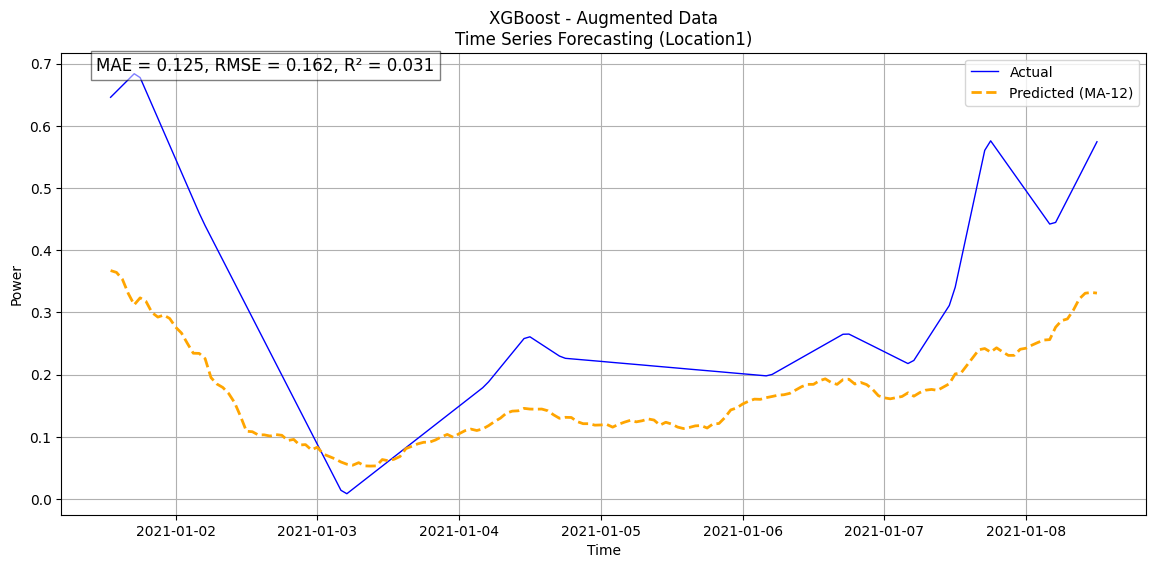

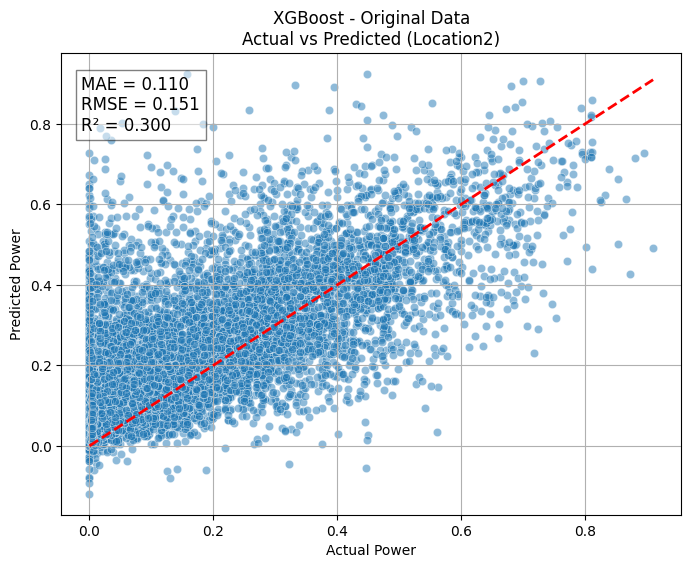

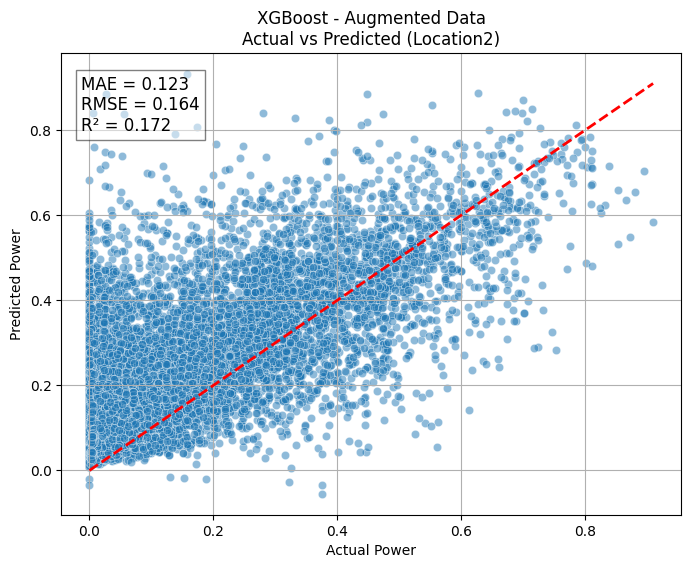

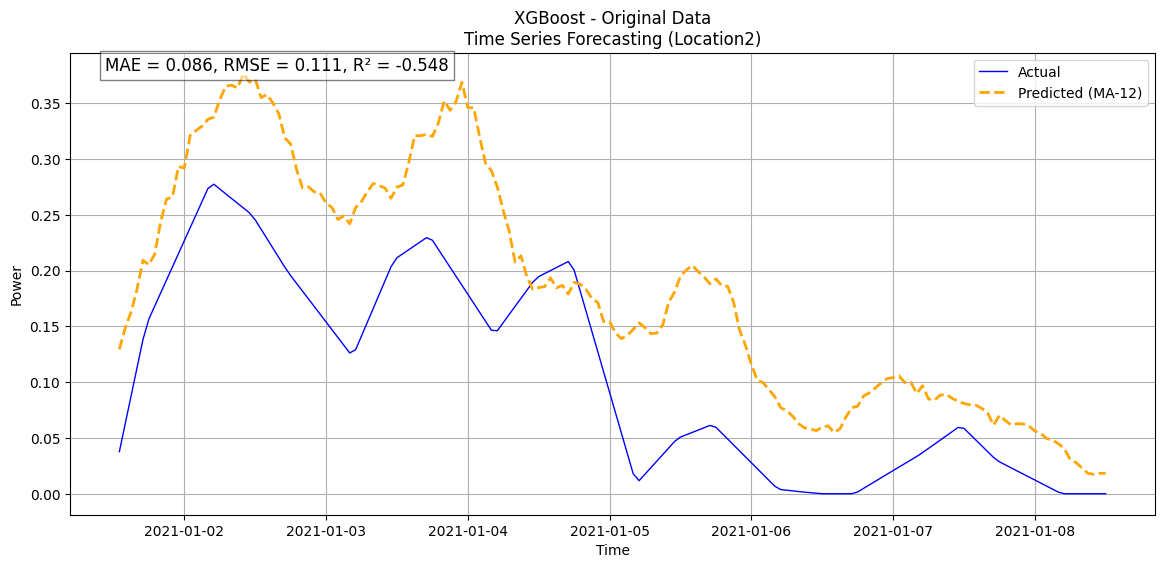

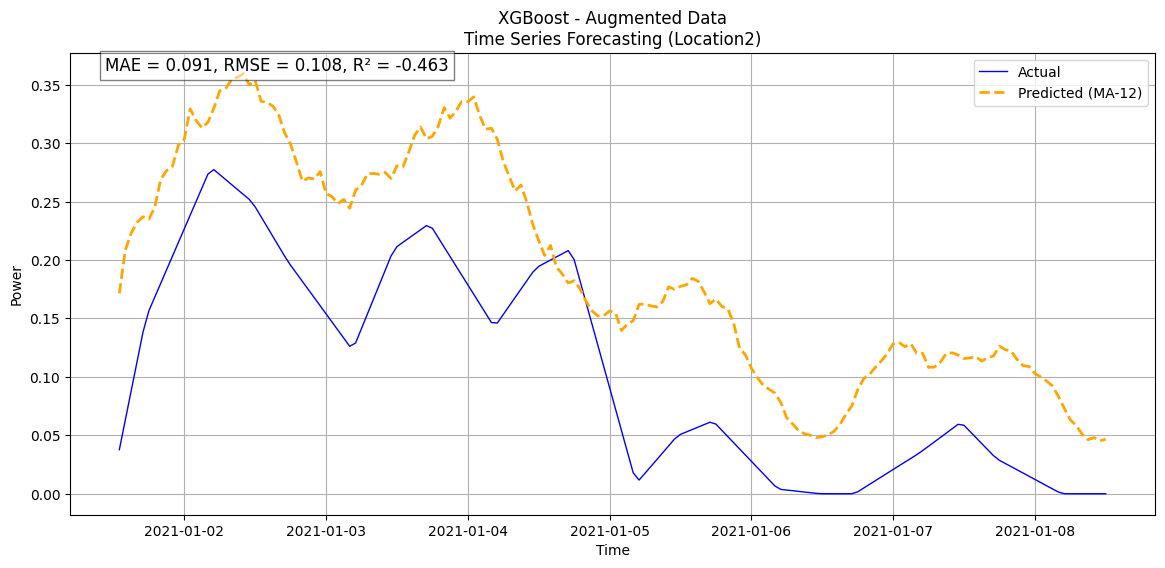

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# =========
# Functions
# =========

def calculate_errors(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def moving_average(series, window):
    return pd.Series(series).rolling(window=window, center=True, min_periods=1).mean()

def plot_actual_vs_predicted(y_true, y_pred, model_name, dataset_name, location):
    mae, rmse, r2 = calculate_errors(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Power')
    plt.ylabel('Predicted Power')
    plt.title(f'{model_name} - {dataset_name}\nActual vs Predicted ({location})')
    plt.grid(True)
    
    textstr = f"MAE = {mae:.3f}\nRMSE = {rmse:.3f}\nR² = {r2:.3f}"
    plt.gcf().text(0.15, 0.75, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

def plot_timeseries(y_true, y_pred, timestamps, model_name, dataset_name, location, smooth_window=12):
    mae, rmse, r2 = calculate_errors(y_true, y_pred)
    
    # Apply moving average to predictions
    y_pred_smoothed = moving_average(y_pred, window=smooth_window)
    
    plt.figure(figsize=(14, 6))
    plt.plot(timestamps, y_true, label='Actual', color='blue', linewidth=1)
    plt.plot(timestamps, y_pred_smoothed, label=f'Predicted (MA-{smooth_window})', color='orange', linestyle='--', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Power')
    plt.title(f'{model_name} - {dataset_name}\nTime Series Forecasting ({location})')
    plt.legend()
    plt.grid(True)
    
    textstr = f"MAE = {mae:.3f}, RMSE = {rmse:.3f}, R² = {r2:.3f}"
    plt.gcf().text(0.15, 0.85, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

# =========
# Location-wise visualization
# =========

locations = org_test_lagged['Location'].unique()

for loc in locations:
    # Extract data for this location
    loc_mask = org_test_lagged['Location'] == loc
    X_test_loc = org_test_lagged[features][loc_mask]
    y_test_loc = org_test_lagged[target][loc_mask]
    timestamps_loc = org_test_lagged['Timestamp'][loc_mask]
    
    # Predictions
    y_pred_org = xgb_org.predict(X_test_loc)
    y_pred_aug = xgb_aug.predict(X_test_loc)
    
    # Scatter plots
    plot_actual_vs_predicted(y_test_loc, y_pred_org, model_name='XGBoost', dataset_name='Original Data', location=loc)
    plot_actual_vs_predicted(y_test_loc, y_pred_aug, model_name='XGBoost', dataset_name='Augmented Data', location=loc)
    
    # Time series plots (only small subset for clarity)
    subset_size = 7*4*6  # ~1 week worth (adjust if needed)
    subset_X = X_test_loc.iloc[:subset_size]
    subset_y = y_test_loc.iloc[:subset_size]
    subset_t = timestamps_loc.iloc[:subset_size]
    
    y_pred_org_subset = xgb_org.predict(subset_X)
    y_pred_aug_subset = xgb_aug.predict(subset_X)
    
    plot_timeseries(subset_y, y_pred_org_subset, subset_t, model_name='XGBoost', dataset_name='Original Data', location=loc)
    plot_timeseries(subset_y, y_pred_aug_subset, subset_t, model_name='XGBoost', dataset_name='Augmented Data', location=loc)
